<a href="https://colab.research.google.com/github/zierenberg/lecture_MC_disease/blob/main/lecture_MonteCarlo_SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm import tqdm


import os

try:
  os.mkdir("figures")
except OSError:
  pass

#plt.rcParams.update({'figure.dpi': 200})
#plt.rcParams.update({'font.size': 22})


Deterministic solution

In [2]:
def SIR_derivative(u, t, rate_infection, rate_recovery):
    S, I, R = u
    N = S + I + R
    dSdt = -rate_infection * S * I / N
    dIdt =  rate_infection * S * I / N - rate_recovery * I
    dRdt =  rate_recovery * I
    return dSdt, dIdt, dRdt

def SIR_deterministic(rate_infection, rate_recovery, S0, I0, R0, times):
  u0 = S0, I0, R0
  
  # Integrate SIR equations over the time grid, t.
  sol = odeint(SIR_derivative, u0, times, args=(rate_infection, rate_recovery))
  S, I, R = sol.T
  return np.array(S), np.array(I), np.array(R)

def exponential_growth(growth_rate, I0, times):
  # Integrate exponential growth
  def derivative(I,t,growth_rate):
    return growth_rate*I
  
  sol = odeint(derivative, I0, times, args=(growth_rate,))
  I, = sol.T
  return I


# Kinetic Monte Carlo Simulation der SIR Dynamik

In [3]:
def simulate(rate_infection, rate_recovery, S0, I0, R0, times):
  S = S0; I = I0; R = R0; 
  time = 0;

  # measurement variables
  trajectory_S = np.zeros(len(times))
  trajectory_I = np.zeros(len(times))
  trajectory_R = np.zeros(len(times))
  i_meas = 0
  if times[i_meas] < 0:
    print("error")
    return -1
  if times[i_meas]==0:
    trajectory_S[0] = S0
    trajectory_I[0] = I0
    trajectory_R[0] = R0
    i_meas = 1

  # kinetic Monte Carlo simulation loop
  while I > 0 and time < times[-1]:
    dt, event = new_event(rate_infection, rate_recovery, S, I, R)
    time += dt

    # measure before update of system, because time will always surpass the 
    # measurement time
    while time > times[i_meas]:
      trajectory_S[i_meas] = S
      trajectory_I[i_meas] = I
      trajectory_R[i_meas] = R
      i_meas += 1
      if i_meas > len(times)-1:
        break
    
    # update system
    if event == "recovery":
      I -= 1
      R += 1
    if event == "infection":
      S -= 1
      I += 1

  return trajectory_S, trajectory_I, trajectory_R
    

In [4]:
def new_event(rate_infection, rate_recovery, S, I, R):
  N = S + I + R

  # calculate rates
  total_rate_infection = rate_infection * I * S / N
  total_rate_recovery  = rate_recovery  * I
  total_rate = total_rate_infection + total_rate_recovery

  # draw random exponentially distributed inter event time
  dt = np.random.exponential(1/total_rate)

  # select event with weight determinde by rate 
  event = ""
  if np.random.rand() < total_rate_infection/total_rate:
    event = "infection"
  else:
    event = "recovery"

  return dt, event

Example

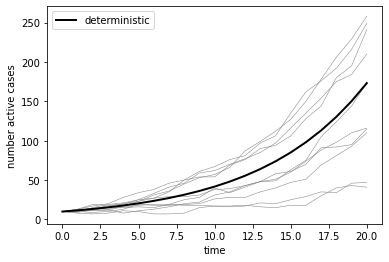

In [5]:
rate_recovery  = 1/7
rate_infection = 2/7
I0 = 10
N = int(1e5)
S0 = N-I0
R0 = 0
time_total = 21

np.random.seed(1000)

num_trajectories = 10
times = np.arange(0, time_total, 1)
for i in range(num_trajectories):
  S, I, R = simulate(rate_infection, rate_recovery, S0, I0, R0, times)

  plt.plot(times, I, color='gray', linewidth=0.5)

# deterministic solution
S_det, I_det, R_det = SIR_deterministic(rate_infection, rate_recovery, S0, I0, R0, times)
plt.plot(times, I_det, color='black', label='deterministic', linewidth=2)

plt.xlabel('time')
plt.ylabel('number active cases')
plt.legend()
plt.savefig('figures/kineticMC_example_I0_10.png', dpi=200)

Extreme example

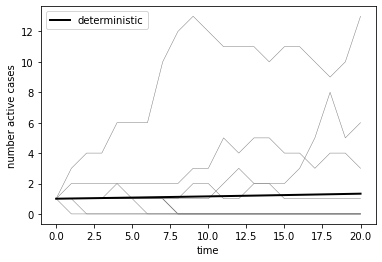

In [6]:
rate_recovery  = 1/7.
rate_infection = 1.1/7.
I0 = 1
N = int(1e5)
S0 = N-I0
R0 = 0
time_total = 21

np.random.seed(1000)

num_trajectories = 10
times = np.arange(0, time_total, 1)
for i in range(num_trajectories):
  S,I,R = simulate(rate_infection, rate_recovery, S0, I0, R0, times)
  plt.plot(times, I, color='gray', linewidth=0.5)

# deterministic solution
S_det, I_det, R_det = SIR_deterministic(rate_infection, rate_recovery, S0, I0, R0, times)
plt.plot(times, I_det, color='black', label='deterministic', linewidth=2)

plt.xlabel('time')
plt.ylabel('number active cases')
plt.legend()
plt.savefig('figures/kineticMC_example_I0_1.png', dpi=200)

# Bayesian Inference SIR
Metropolis parameter sampling of SIR model:

P(parameter|daten) = P(daten|parameter) * P(parameter)

Choices:
* P(parameter): 
   
   rate_infection in [0,1]

   rate_recovery in [0,1]
   
   I0 in [1,100]
* P(daten|parameter) = (I(data)-I(model)))^2 [least squares]




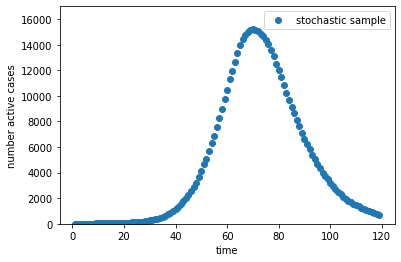

In [7]:

# data source
np.random.seed(2000)
times = np.arange(1,120,1)
S, data_I_long, R = simulate(2/7, 1/7, S0, 10, R0, times)

plt.plot(times, data_I_long, 'o', label='stochastic sample')

plt.ylim(0,17000)
plt.xlabel('time')
plt.ylabel('number active cases')
plt.legend()
#plt.show()
plt.savefig('figures/inference_example_SIR_data.png', dpi=200)


In [8]:

# likelihood is product of Gaussians with variance sqrt(data)
def log_likelihood(data_I, model_I):
  return -np.sum(np.power(model_I-data_I,2)/2/data_I)

def parameter_proposal(p, dp):
  return p + (-1 + 2 * np.random.rand()) *dp

# known parameters
S0 = int(1e5)
R0 = 0
times = np.arange(1,120,1)

# initial parameter
I0 = 1
rate_infection = 0.1
rate_recovery  = 0.1
S,model_I,R = SIR_deterministic(rate_infection, rate_recovery, S0, I0, R0, times)
logL = log_likelihood(data_I_long, model_I)

SIR_samples_I0 = [I0]
SIR_samples_rate_infection = [rate_infection]
SIR_samples_rate_recovery = [rate_recovery]
SIR_samples_logL = [logL]

SIR_best_fit = (logL, I0, rate_infection, rate_recovery)

np.random.seed(1000)
num_updates = int(1e5)
dI0 = 0.1
drate = 0.01
for i in tqdm(range(num_updates)):
  #propose new parameters
  new_I0 = I0
  new_rate_infection = rate_infection
  new_rate_recovery = rate_recovery
  p_select = np.random.rand()
  if (p_select < 1/3.):
    new_I0 = parameter_proposal(I0, dI0)
  elif (p_select < 2/3.):
    new_rate_infection = parameter_proposal(rate_infection, drate)
  else:
    new_rate_recovery  = parameter_proposal(rate_recovery,  drate)

  # accept or reject new parameters
  if (1 < new_I0 < 100) \
   and (0 < new_rate_recovery < 1) \
   and (0 < new_rate_infection < 1):
    S,model_I,R = SIR_deterministic(new_rate_infection, new_rate_recovery, \
                                    S0, new_I0, R0, times)
    new_logL = log_likelihood(data_I_long, model_I)
    #accept with weight P(new)/P(old)
    if np.random.rand() < np.exp(new_logL - logL): 
      I0 = new_I0
      rate_infection = new_rate_infection
      rate_recovery = new_rate_recovery
      logL = new_logL

  # store best fit
  if logL > SIR_best_fit[0]:
    SIR_best_fit = (logL, I0, rate_infection, rate_recovery)

  SIR_samples_I0.append(I0)
  SIR_samples_rate_infection.append(rate_infection)
  SIR_samples_rate_recovery.append(rate_recovery)
  SIR_samples_logL.append(logL)

100%|██████████| 100000/100000 [01:58<00:00, 840.43it/s]


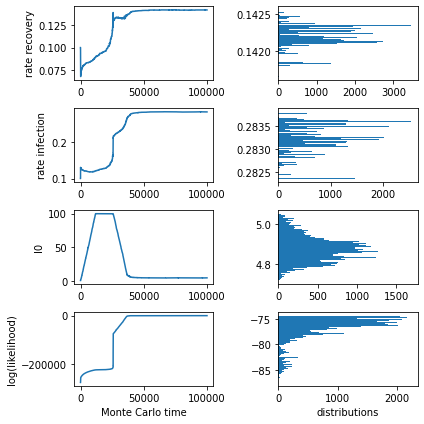

In [9]:
fig, axs = plt.subplots(4, 2, sharey=False, tight_layout=True, figsize=(6,6))

num_equilibration = int(5e4)

axs[0,0].plot(SIR_samples_rate_recovery)
axs[1,0].plot(SIR_samples_rate_infection)
axs[2,0].plot(SIR_samples_I0)
axs[3,0].plot(SIR_samples_logL)
axs[0,1].hist(SIR_samples_rate_recovery[num_equilibration:], 100, orientation="horizontal");
axs[1,1].hist(SIR_samples_rate_infection[num_equilibration:], 100, orientation="horizontal");
axs[2,1].hist(SIR_samples_I0[num_equilibration:], 100, orientation="horizontal");
axs[3,1].hist(SIR_samples_logL[num_equilibration:], 100, orientation="horizontal");

axs[3,0].set_xlabel("Monte Carlo time")
axs[3,1].set_xlabel("distributions")

axs[0,0].set_ylabel("rate recovery")
axs[1,0].set_ylabel("rate infection")
axs[2,0].set_ylabel("I0")
axs[3,0].set_ylabel("log(likelihood)")

plt.savefig('figures/inference_example_SIR_MC.png', dpi=200)

truth: -42931.56105855961 10 0.2857142857142857 0.14285714285714285
best fit: (-74.36513594743387, 4.801935021066452, 0.2836168932292803, 0.14236636995404373)
expectation: 0.2834310748078799 0.14228767142942236


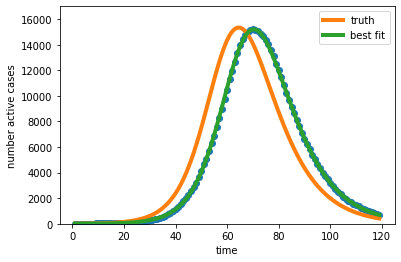

In [10]:
S0 = int(1e5)
R0 = 0
I0 = 10
times = np.arange(1,120,1)
S, model_truth, R = SIR_deterministic(2/7, 1/7, S0, I0, R0, times)
print("truth:",log_likelihood(data_I_long, model_truth), 10, 2/7, 1/7)

print("best fit:",SIR_best_fit)
logL, I0, rate_infection, rate_recovery = SIR_best_fit
S, model_I, R = SIR_deterministic(rate_infection, rate_recovery, S0, I0, R0, times)

samples_rate_infection = np.array(SIR_samples_rate_infection)
samples_rate_recovery = np.array(SIR_samples_rate_recovery)
samples_logL = np.array(SIR_samples_logL)

print("expectation:", 
      np.sum(samples_rate_infection[num_equilibration:]*np.exp(samples_logL[num_equilibration:]))/np.sum(np.exp(samples_logL[num_equilibration:])),
      np.sum(samples_rate_recovery[num_equilibration:]*np.exp(samples_logL[num_equilibration:])/np.sum(np.exp(samples_logL[num_equilibration:]))) )


plt.plot(times, data_I_long, 'o')
plt.plot(times, model_truth, label='truth', linewidth=4)
plt.plot(times, model_I, label = 'best fit', linewidth=4)

plt.ylim(0,17000)
plt.legend()
plt.xlabel('time')
plt.ylabel('number active cases')
plt.savefig('figures//inference_example_SIR_bestfit.png', dpi=200)

#credibility interval
indices_sorted = samples_logL.argsort()

# Bayesian Inference exponential growth

Metropolis parameter sampling of exponential growth:

P(parameter|daten) = P(daten|parameter) * P(parameter)

Choices:
* P(parameter): 
   
   growth_rate uniform in [-3,3]
   
   I0 in [1,100]
* P(daten|parameter) = (I(data)/I(model) - 1))^2 [least squares]

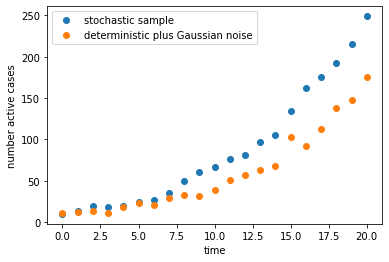

In [11]:
# random sample (I0=10, rate_infection=3/7, rate_recovery=1/7)
times = np.arange(0,21,1)
S_sample = np.array([99990,99985,99978,99974,99968,99960,99955,99946,99927,99911,99895,99876,99856,99824,99804,99764,99722,99682,99637,99589,99527])
I_sample = np.array([10,13,19,18,19,25,27,35,50,61,67,76,81,97,106,135,162,176,192,216,249])
S_det, I_det, R_det = SIR_deterministic(2/7, 1/7, int(1e5)-10, 10, 0, times)
I_noise = I_det + np.random.normal(0,np.sqrt(I_det),len(times))

plt.plot(times, I_sample, 'o', label='stochastic sample')
plt.plot(times, I_noise,  'o', label='deterministic plus Gaussian noise')

plt.xlabel('time')
plt.ylabel('number active cases')
plt.legend()
plt.savefig('figures/inference_example_exponential_data.png', dpi=200)

In [12]:
def log_likelihood(data_I, model_I):
  return -np.sum(np.power(model_I-data_I,2)/2/data_I)

def parameter_proposal(p, dp):
  return p + (-1 + 2 * np.random.rand())*dp

data_I = I_sample

I0 = 1
growth_rate = 0
model_I = exponential_growth(growth_rate, I0, times)
logL = log_likelihood(data_I, model_I)

samples_I0 = [I0]
samples_growth_rate = [growth_rate]
samples_logL = [logL]

best_fit = (logL, I0, growth_rate)

np.random.seed(1000)
num_updates = int(1e5)
dI0 = 0.1
drate = 0.01
for i in tqdm(range(num_updates)):
  #propose new parameters
  p_select = np.random.rand()
  new_I0 = I0
  new_growth_rate = growth_rate
  if p_select < 0.5:
    new_I0 = parameter_proposal(I0, dI0)
  else:
    new_growth_rate = parameter_proposal(growth_rate, drate)

  if (1 <new_I0 < 100) and (-3 < new_growth_rate < 3):
    model_I = exponential_growth(new_growth_rate, new_I0, times)
    new_logL = log_likelihood(data_I, model_I)
    if np.random.rand() < np.exp(new_logL-logL): # accept
      I0 = new_I0
      growth_rate = new_growth_rate
      logL = new_logL

  if logL > best_fit[0]:
    best_fit = (logL, I0, growth_rate)

  samples_I0.append(I0)
  samples_growth_rate.append(growth_rate)
  samples_logL.append(logL)

100%|██████████| 100000/100000 [00:19<00:00, 5034.50it/s]


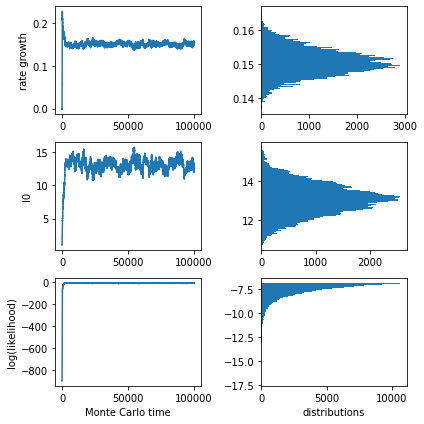

In [13]:
fig, axs = plt.subplots(3, 2, sharey=False, tight_layout=True, figsize=(6,6))

num_equilibration = int(10000)
axs[0,0].plot(samples_growth_rate)
axs[1,0].plot(samples_I0)
axs[2,0].plot(samples_logL)
axs[0,1].hist(samples_growth_rate[num_equilibration:], 100, orientation="horizontal");
axs[1,1].hist(samples_I0[num_equilibration:], 100, orientation="horizontal");
axs[2,1].hist(samples_logL[num_equilibration:], 100, orientation="horizontal");

axs[2,0].set_xlabel("Monte Carlo time")
axs[2,1].set_xlabel("distributions")

axs[0,0].set_ylabel("rate growth")
axs[1,0].set_ylabel("I0")
axs[2,0].set_ylabel("log(likelihood)")

plt.savefig('figures/inference_example_exponential_MC.png', dpi=200)

truth: -99.15637621733973 10 0.14285714285714285
best fit: (-6.839972942272492, 13.076948312090098, 0.15057840525694138)
expectation: 0.15057545821887497


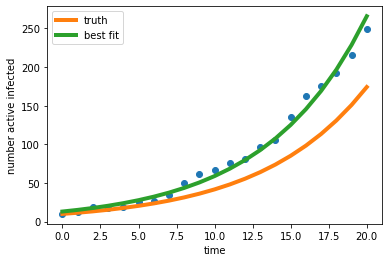

In [14]:
times=np.arange(0,21,1)
model_truth = exponential_growth(1/7, 10, times)
print("truth:",log_likelihood(data_I, model_truth), 10, 1/7)

print("best fit:",best_fit)
logL, I0, growth_rate = best_fit
model_I = exponential_growth(growth_rate, I0, times)

samples_growth_rate = np.array(samples_growth_rate)
samples_logL = np.array(samples_logL)

print("expectation:", 
      np.sum(samples_growth_rate[num_equilibration:]*np.exp(samples_logL[num_equilibration:]))/np.sum(np.exp(samples_logL[num_equilibration:]))
      )

plt.plot(times, data_I, 'o')
plt.plot(times, model_truth, label='truth', linewidth=4)
plt.plot(times, model_I, label = 'best fit', linewidth=4)

plt.xlabel('time')
plt.ylabel('number active infected')
plt.legend()
plt.savefig('figures/inference_example_exponential_bestfit.png', dpi=200)

# Export

In [16]:
! zip figures.zip figures/* 

  adding: figures/inference_example_exponential_bestfit.png (deflated 8%)
  adding: figures/inference_example_exponential_data.png (deflated 14%)
  adding: figures/inference_example_exponential_MC.png (deflated 11%)
  adding: figures/inference_example_SIR_bestfit.png (deflated 6%)
  adding: figures/inference_example_SIR_data.png (deflated 12%)
  adding: figures/inference_example_SIR_MC.png (deflated 10%)
  adding: figures/kineticMC_example_I0_10.png (deflated 12%)
  adding: figures/kineticMC_example_I0_1.png (deflated 15%)
